## Imports

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import operator
from functools import reduce
import community as cmt
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
import random
sns.set(rc={'figure.figsize':(16,9)})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Loading the datasets

In [4]:
routes = pd.read_csv('routes.dat.txt', header=None)
routes.columns = ['Airline',
                'Airline ID',
                'Source airport',
                'Source airport ID',
                'Destination airport',
                'Destination airport ID',
                'Codeshare',
                'Stops',
                'Equipment']

airports = pd.read_csv('airports.dat.txt', header=None, index_col=4, na_values='\\N')
airports.columns = ['Airport ID',
                    'Name',
                    'City',
                    'Country',
                    'ICAO',
                    'Latitude',
                    'Longitude',
                    'Altitude',
                    'Timezone',
                    'DST',
                    'TZ',
                    'Type',
                    'Source']

In [5]:
routes.head()
#routes.info()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [6]:
airports.head()

,Airport ID,Name,City,Country,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type,Source
4,,,,,,,,,,,,,
GKA,1,Goroka Airport,Goroka,Papua New Guinea,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
MAG,2,Madang Airport,Madang,Papua New Guinea,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
HGU,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
LAE,4,Nadzab Airport,Nadzab,Papua New Guinea,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
POM,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


In [7]:
#find airports in China
airports_cn = airports[airports['Country']=='China']
airports_cn.head()

,Airport ID,Name,City,Country,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type,Source
4,,,,,,,,,,,,,
PEK,3364,Beijing Capital International Airport,Beijing,China,ZBAA,40.080101,116.584999,116,8.0,U,Asia/Shanghai,airport,OurAirports
HLD,3366,Dongshan Airport,Hailar,China,ZBLA,49.205002,119.824997,2169,8.0,U,Asia/Shanghai,airport,OurAirports
TSN,3368,Tianjin Binhai International Airport,Tianjin,China,ZBTJ,39.124401,117.346001,10,8.0,U,Asia/Shanghai,airport,OurAirports
TYN,3369,Taiyuan Wusu Airport,Taiyuan,China,ZBYN,37.746899,112.627998,2575,8.0,U,Asia/Shanghai,airport,OurAirports
CAN,3370,Guangzhou Baiyun International Airport,Guangzhou,China,ZGGG,23.392401,113.299004,50,8.0,U,Asia/Shanghai,airport,OurAirports


In [8]:
airports_cn_ls=airports_cn['Airport ID'].tolist()
#print(airports_cn_ls)

In [9]:
routes=routes[(routes['Source airport ID']!='\\N') & (routes['Destination airport ID']!='\\N')]
routes[['Source airport ID','Destination airport ID']]=routes[['Source airport ID','Destination airport ID']].astype(int)
#print(routes.dtypes)

## Cleaning

In [10]:
#find the routes from or to China
routes=routes[(routes['Source airport ID'].isin(airports_cn_ls)) | (routes['Destination airport ID'].isin(airports_cn_ls))]
#print(routes.head())
#Find common airport between both datasets airport.dat and route.dat
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))
airports_air = list(airports.index)
nodes = list(set(airports_air) & set(airports_route))

#We keep the edges that start and arrive at know airports
routes_clean = routes[(routes['Source airport'].isin(nodes)) & (routes['Destination airport'].isin(nodes))]
airports_clean = airports[airports.index.isin(nodes)]
#print(airports_clean['Airport ID'].duplicated())

In [11]:
#altitude and longitude of source and destinaation airports
airports_titude=airports_clean[['Airport ID','Latitude','Longitude']]
routes_clean=pd.merge(routes_clean,airports_titude,how='left',left_on='Source airport ID',right_on='Airport ID',
                      sort=False)
routes_clean=routes_clean.rename(columns={'Latitude':'Source latitude','Longitude':'Source longitude'})
routes_clean=pd.merge(routes_clean,airports_titude,how='left',left_on='Destination airport ID',right_on='Airport ID',
                      sort=False)
routes_clean=routes_clean.rename(columns={'Latitude':'Destination latitude','Longitude':'Destination longitude'})
routes_clean=routes_clean.drop(['Airport ID_x','Airport ID_y'],axis=1)

In [12]:
#distance of the route
def dis(row):
    try:
        return(geodesic((row['Source latitude'], row['Source longitude']), 
                      (row['Destination latitude'], row['Destination longitude'])).km)
    except ValueError:
        return np.nan
routes_clean['Distance'] = routes_clean.apply(lambda row : dis(row),axis=1)
    

In [14]:
routes_clean.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment,Source latitude,Source longitude,Destination latitude,Destination longitude,Distance
0,3K,3021,HAK,4120,SIN,3316,NaN,0,320,19.93490,110.459000,1.35019,103.994003,2173.039882
1,3K,3021,HGH,3386,SIN,3316,NaN,0,320,30.22950,120.433998,1.35019,103.994003,3638.040845
2,3K,3021,SIN,3316,HAK,4120,NaN,0,320,1.35019,103.994003,19.93490,110.459000,2173.039882
3,3K,3021,SIN,3316,HGH,3386,NaN,0,320,1.35019,103.994003,30.22950,120.433998,3638.040845
4,3K,3021,SIN,3316,SWA,4302,NaN,0,320,1.35019,103.994003,23.55200,116.503300,2802.938866


**Save the clean data**

In [15]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

## Data Exploration

**Load clean data**

In [16]:
routes = pd.read_csv('routes_clean.csv', low_memory=False)
airports = pd.read_csv('airports_clean.csv', index_col=0)

**Create graph using networkx from a list of edges**

In [17]:
#we can add attributes here
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

**Statistics to explore**
- average degree
- connected components
- diameter
- centrality measures (computed from the shortest paths)
- graph density
- pagerank
- eigenvector centrality

### Degree ditribution

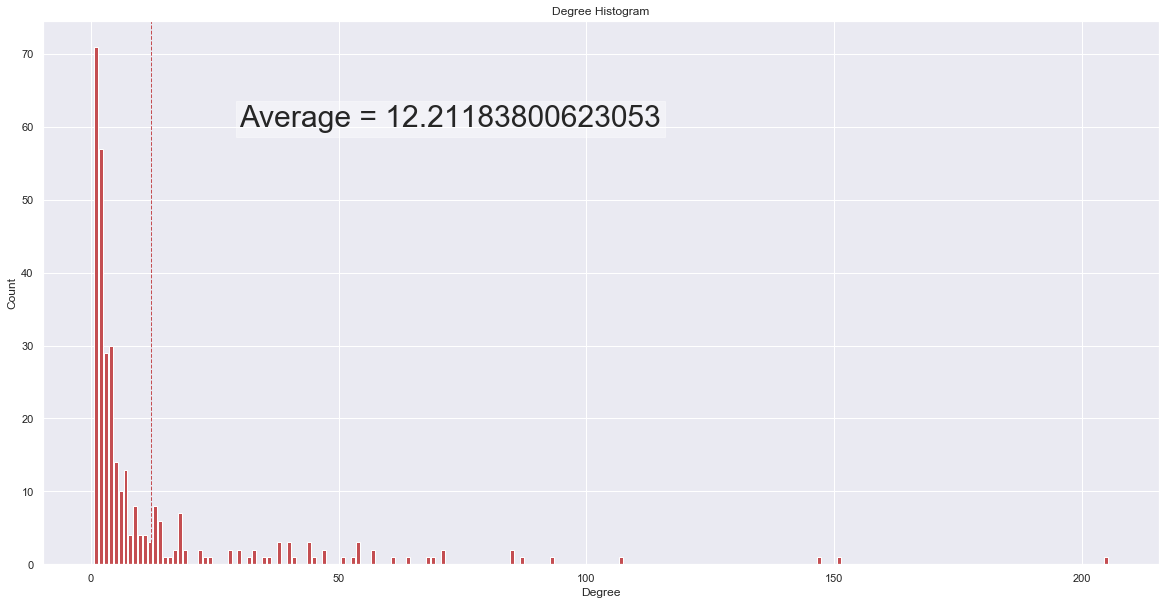

In [28]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (20,10))
plt.bar(deg, cnt, width=0.80, color='r')
mean = np.array(degree_sequence).mean()
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.text(30,60,'Average = {}'.format(mean),bbox=dict(facecolor='white', alpha=0.4), fontsize=30)
plt.show()

## Graph connectivity

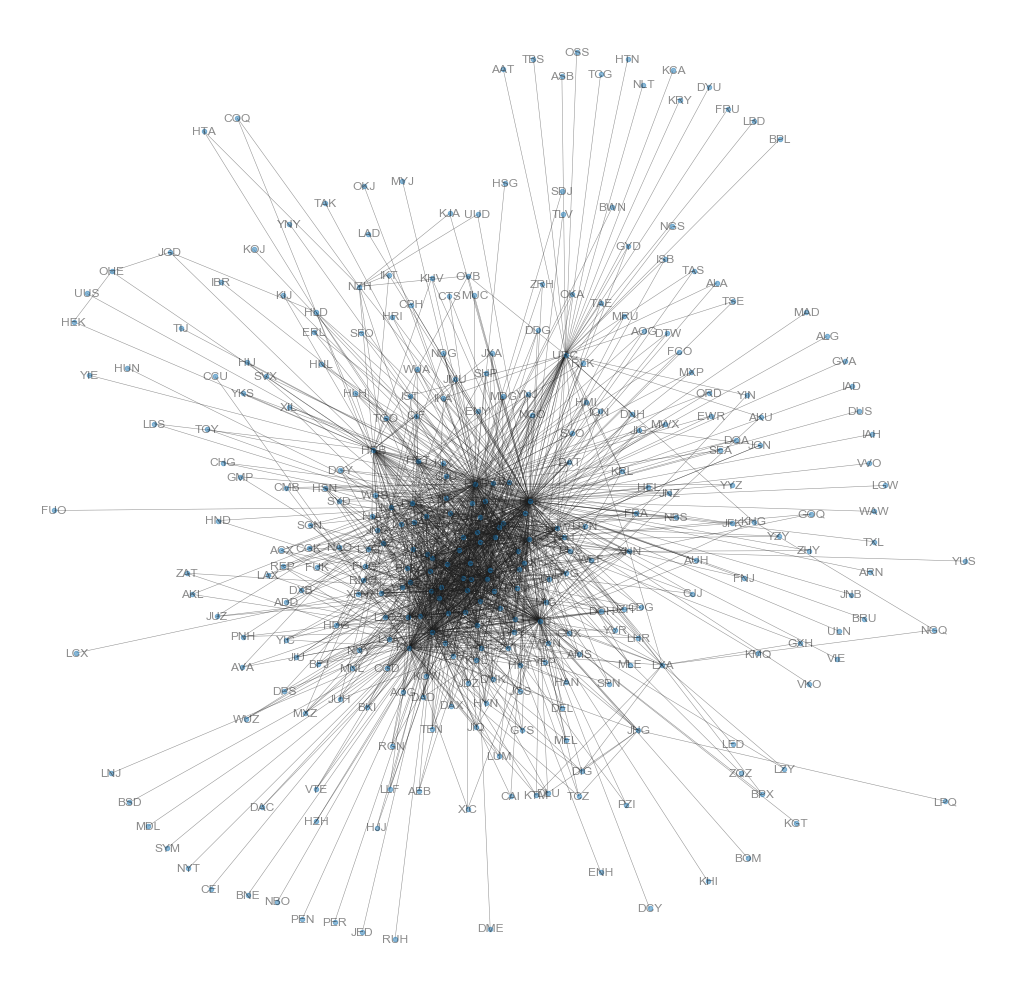

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=20, alpha=.5,
                 width=.5, with_labels=True)
ax.set_axis_off()

In [24]:
print("We can see that our graph is not connected. In fact, there are", nx.number_connected_components(G), "components in total.")

We can see that our graph is not connected. In fact, there are 1 components in total.


In [25]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
largest_cc = max(connected_component_subgraphs(G), key=len)

In [26]:
print("We get the largest connected component for the continuation. It contains", len(largest_cc),"nodes.")

We get the largest connected component for the continuation. It contains 321 nodes.


### Largest component diameter 

In [27]:
print("The diameter of the graph is the length of the longest shortest path between any pair of nodes.")
print("The diameter of our graph is", nx.diameter(largest_cc))

The diameter of the graph is the length of the longest shortest path between any pair of nodes.
The diameter of our graph is 5


### Clutering coefficient

**The neighborhood of a node u, is the set of nodes that are connected to u**. The clustetring coefficient of a node  **u**  is the fraction of the node’s neighbors that are connected. Finally, we obtain the average clustering coefficient by averaging this value over all nodes of the graph.

In [28]:
print("Our graph has a clustering coefficient of", nx.average_clustering(largest_cc))

Our graph has a clustering coefficient of 0.6191200226324888


### Centrality

Centrality is a mesure of importance of nodes/edges in a network

In [35]:
#Helper functions
def get_NameCity(ID):
    row = airports.loc[ID]
    return row['Name'], row['City']

def plot_dict(dict_, k, name):
    

    def print_rank(l):
        for k in range(len(l)):

            a,b = get_NameCity(l[k])
            print('{}. {}, {}'.format(k+1,a,b))
            
    
    airports, values = list(dict_.keys()), list(dict_.values())
    sort_index = list(np.argsort(values))
    airports_s = np.array(airports)[sort_index][::-1] #k highest ranked
    values_s = np.array(values)[sort_index][::-1]

    sns.barplot(x=airports_s[:k], y=values_s[:k],palette="deep", label='small')
    
    print('- In means of {} : Top 15 respectively are : '.format(name,k))
    print_rank(airports_s[:k])
    return list(zip(airports_s, np.array(range(len(airports_s)))+1))


#### Betweenness centrality:
Betweenness centrality mesures how much nodes/edges are part of shortest paths

- In means of betweenness : Top 15 respectively are : 
1. Beijing Capital International Airport, Beijing
2. Shanghai Pudong International Airport, Shanghai
3. Guangzhou Baiyun International Airport, Guangzhou
4. Ürümqi Diwopu International Airport, Urumqi
5. Chengdu Shuangliu International Airport, Chengdu
6. Kunming Changshui International Airport, Kunming
7. Xi'an Xianyang International Airport, Xi'an
8. Taiping Airport, Harbin
9. Chongqing Jiangbei International Airport, Chongqing
10. Shenzhen Bao'an International Airport, Shenzhen
11. Shanghai Hongqiao International Airport, Shanghai
12. Hangzhou Xiaoshan International Airport, Hangzhou
13. Beijing Nanyuan Airport, Beijing
14. Zhoushuizi Airport, Dalian
15. Baita International Airport, Hohhot


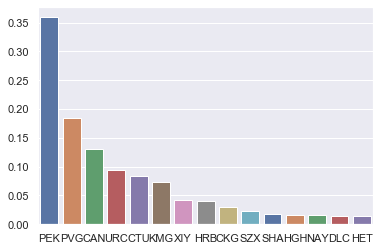

In [30]:
betweenness = nx.betweenness_centrality(largest_cc)
bet_sort = plot_dict(betweenness,15,'betweenness')


#### Eigenvalue centrality:
Eigenvalue centrality mesures how much nodes are connected to nodes with high betweenness centrality

- In means of eigenvectors : Top 15 respectively are : 
1. Beijing Capital International Airport, Beijing
2. Guangzhou Baiyun International Airport, Guangzhou
3. Shanghai Pudong International Airport, Shanghai
4. Chengdu Shuangliu International Airport, Chengdu
5. Chongqing Jiangbei International Airport, Chongqing
6. Shenzhen Bao'an International Airport, Shenzhen
7. Xi'an Xianyang International Airport, Xi'an
8. Kunming Changshui International Airport, Kunming
9. Changsha Huanghua International Airport, Changcha
10. Xiamen Gaoqi International Airport, Xiamen
11. Wuhan Tianhe International Airport, Wuhan
12. Hangzhou Xiaoshan International Airport, Hangzhou
13. Shanghai Hongqiao International Airport, Shanghai
14. Zhengzhou Xinzheng International Airport, Zhengzhou
15. Nanjing Lukou Airport, Nanjing


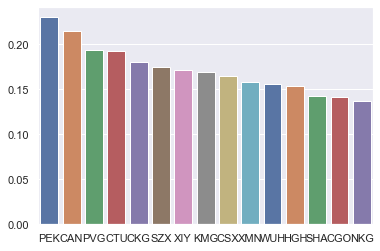

In [31]:
eigenve = nx.eigenvector_centrality(largest_cc)
eig_sort = plot_dict(eigenve, 15, 'eigenvectors')

### PageRank
PageRank is a variant of eigenvalue centrality

- In means of pagerank : Top 15 respectively are : 
1. Beijing Capital International Airport, Beijing
2. Shanghai Pudong International Airport, Shanghai
3. Guangzhou Baiyun International Airport, Guangzhou
4. Chengdu Shuangliu International Airport, Chengdu
5. Kunming Changshui International Airport, Kunming
6. Ürümqi Diwopu International Airport, Urumqi
7. Xi'an Xianyang International Airport, Xi'an
8. Chongqing Jiangbei International Airport, Chongqing
9. Shenzhen Bao'an International Airport, Shenzhen
10. Hangzhou Xiaoshan International Airport, Hangzhou
11. Shanghai Hongqiao International Airport, Shanghai
12. Xiamen Gaoqi International Airport, Xiamen
13. Taiping Airport, Harbin
14. Changsha Huanghua International Airport, Changcha
15. Wuhan Tianhe International Airport, Wuhan


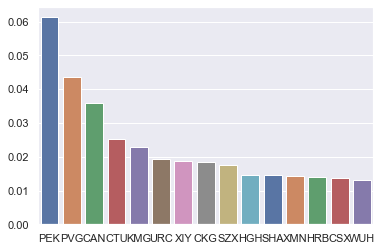

In [32]:
pagerank = nx.pagerank(largest_cc)
pr_sort = plot_dict(pagerank, 15, 'pagerank')

In [33]:
bt = pd.DataFrame(bet_sort, columns = ['Airport ID', 'Betweenness']) 
eg = pd.DataFrame(eig_sort, columns = ['Airport ID', 'EigenVectors']) 
pr = pd.DataFrame(pr_sort, columns = ['Airport ID', 'PageRank']) 

dfs = [bt, eg, pr]
df_final = reduce(lambda left,right: pd.merge(left,right,on='Airport ID'), dfs)
df_final['Average'] = (df_final['Betweenness']+df_final['EigenVectors']+df_final['PageRank'])/3
df_final.sort_values('Average',inplace=True)
df_final.reset_index(drop = True,inplace=True)
df_final['OverAll Rank'] = np.array(df_final.index)+1
df_final.set_index('Airport ID',inplace=True)
namecity = pd.Series(df_final.index).apply(lambda x : str('{}, {}'.format(get_NameCity(x)[0],get_NameCity(x)[1])))
df_final.reset_index(inplace=True)
df_final['Airport Name, City'] = namecity
df_final.set_index('Airport ID',inplace=True)
df_final.head(15)

,Betweenness,EigenVectors,PageRank,Average,OverAll Rank,"Airport Name, City"
Airport ID,,,,,,
PEK,1,1,1,1.000000,1,"Beijing Capital International Airport, Beijing"
PVG,2,3,2,2.333333,2,"Shanghai Pudong International Airport, Shanghai"
CAN,3,2,3,2.666667,3,"Guangzhou Baiyun International Airport, Guangzhou"
CTU,5,4,4,4.333333,4,"Chengdu Shuangliu International Airport, Chengdu"
KMG,6,8,5,6.333333,5,"Kunming Changshui International Airport, Kunming"
XIY,7,7,7,7.000000,6,"Xi'an Xianyang International Airport, Xi'an"
CKG,9,5,8,7.333333,7,"Chongqing Jiangbei International Airport, Chon..."
SZX,10,6,9,8.333333,8,"Shenzhen Bao'an International Airport, Shenzhen"
HGH,12,12,10,11.333333,9,"Hangzhou Xiaoshan International Airport, Hangzhou"


The above Dataframe shows the ranking ok nodes in term of centrality

## World map

To create the map, we first retrieve the coordinates from the airports dataframe

In [34]:
pos = {airport: (v['Longitude'], v['Latitude'])
       for airport, v in
       airports.to_dict('index').items()}

Node size will be the degree of the nodes

In [35]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

Display label only if degree is quite big

In [36]:
labels = {iata: iata if deg[iata] >= 200 else ''
          for iata in largest_cc.nodes}

In [37]:
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(
        1, 1, figsize=(36, 24),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    # Extent of continental US.
    #ax.set_extent([-128, -62, 20, 50])
    nx.draw_networkx(graph, ax=ax,
                     font_size=30,
                     alpha=.5,
                     width=.2,
                     node_size=sizes,
                     labels=labels,
                     pos=pos,
                     node_color=node_color)

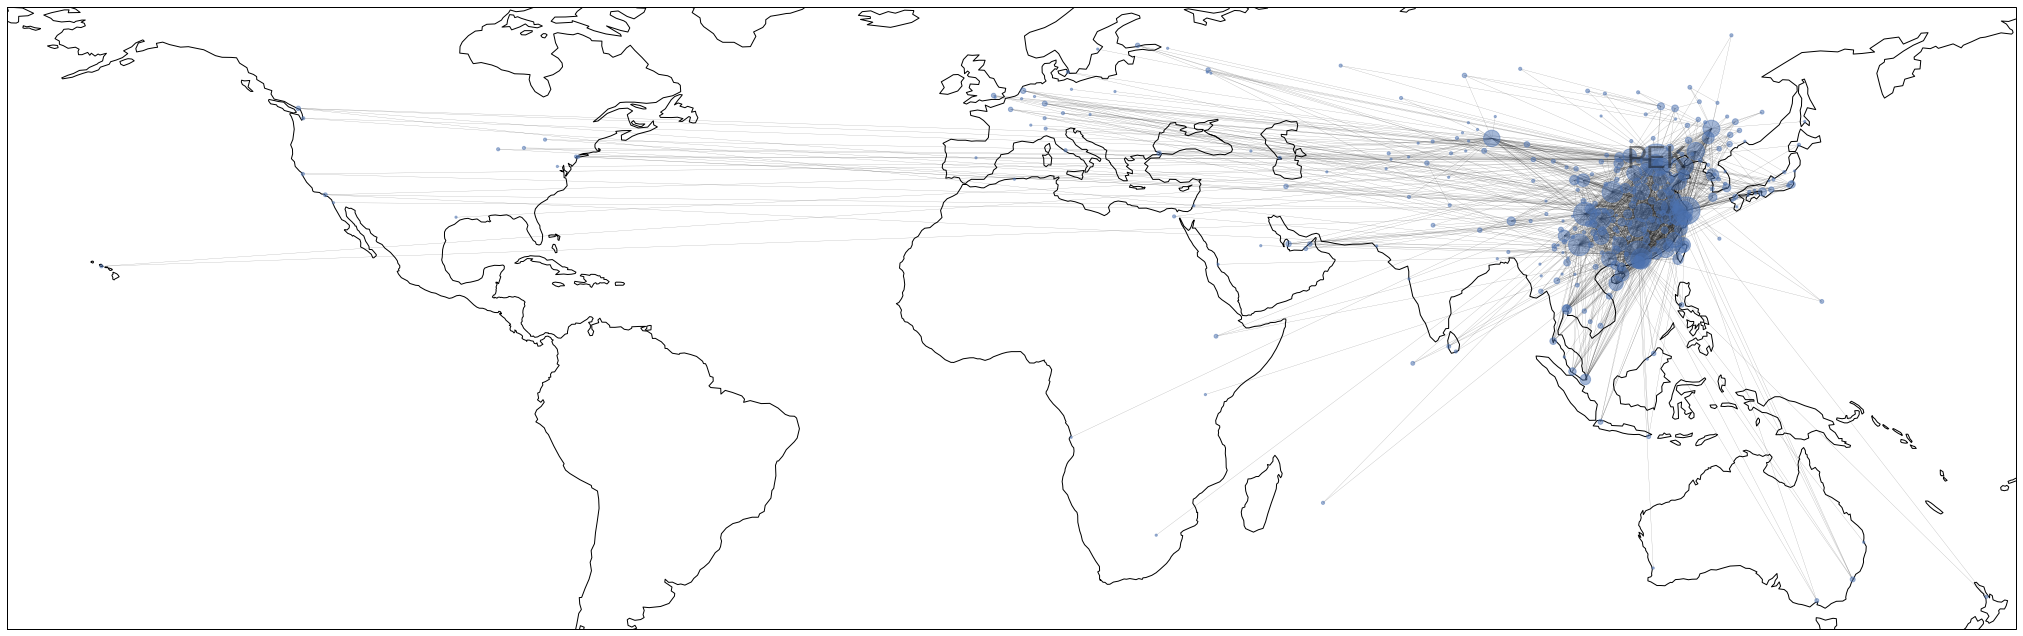

In [38]:
display_map(largest_cc)

## Flight distance

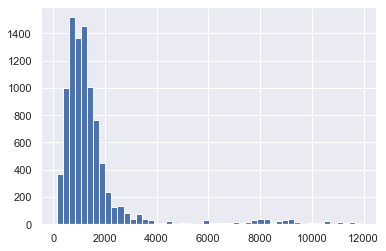

In [39]:
plt.hist(routes_clean['Distance'].values, bins = 50)
plt.show()

The distribution of distances follows a power law with most fly being relatively short distances.

## Local/international flights

In [40]:
airports_country=airports_clean[['Airport ID','Country']]
routes_clean=pd.merge(routes_clean,airports_country,how='left',left_on='Source airport ID',right_on='Airport ID',
                      sort=False)
routes_clean=routes_clean.rename(columns={'Country':'Source country'})
routes_clean=pd.merge(routes_clean,airports_country,how='left',left_on='Destination airport ID',right_on='Airport ID',
                      sort=False)
routes_clean=routes_clean.rename(columns={'Country':'Destination country'})
print(routes_clean.info())
routes_clean=routes_clean.drop(['Airport ID_x','Airport ID_y'],axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9259 entries, 0 to 9258
Data columns (total 18 columns):
Airline                   9259 non-null object
Airline ID                9259 non-null object
Source airport            9259 non-null object
Source airport ID         9259 non-null int64
Destination airport       9259 non-null object
Destination airport ID    9259 non-null int64
Codeshare                 1543 non-null object
Stops                     9259 non-null int64
Equipment                 9259 non-null object
Source latitude           9237 non-null float64
Source longitude          9237 non-null float64
Destination latitude      9237 non-null float64
Destination longitude     9237 non-null float64
Distance                  9215 non-null float64
Airport ID_x              9237 non-null float64
Source country            9237 non-null object
Airport ID_y              9237 non-null float64
Destination country       9237 non-null object
dtypes: float64(7), int64(3), object(8)
mem

In [41]:
#routes_clean['Source country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Country.values.item(0), axis = 1)
#routes_clean['Destination country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Country.values.item(0), axis = 1)

In [42]:
routes_clean['International flight'] = routes_clean.apply(lambda row : not (row['Source country'] == row['Destination country']), axis = 1)

In [43]:
routes_clean['International flight'].value_counts()

False    6851
True     2408
Name: International flight, dtype: int64

We have an even distribution of international and national flights

## Finding communities with Spectral Clustering

In order to perform spectral clustering on our graph, we will first need to compute the laplacian of our graph:

In [44]:
laplacian = nx.laplacian_matrix(largest_cc)
laplacian = laplacian.asfptype()

In [45]:
def compute_embedding(laplacian, dim):
    """Given a graph laplacian and a target dimension, this function
    computes a graph embedding in the chosen dimension. There is the
    option to normalize the eigenvectors in the process."""
    
    #Compute the k first eigenvectors (k depends on the target dimension)
    k_eigenvalues, k_eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=1+dim, which='SA')        

    #Compute the embedding for each node
    embedding = np.zeros((321, dim))
    for i in range(321):
        for k_th in range(dim): 
            embedding[i, k_th] = k_eigenvectors[i, k_th+1]
            
    return embedding



We decided to compute an embedding in 4 dimensions:

In [46]:
embedding = compute_embedding(laplacian, 4)

Here, we show a graph for a 2D embedding, to have a visualization of the communities in our graph:

In [47]:
# Laplacian eigenmaps (coordinates in 2D)
coords = embedding[:, 0:2]

def plot_signal(signal):
    """Display nodes of the graph in 2D
    together with the given signal"""
    
    nodes = nx.draw_networkx_nodes(largest_cc, dict(zip(largest_cc.nodes, coords)), node_size=30, node_color=signal)
    plt.xlabel('Value of $\lambda_1$')
    plt.ylabel('Value of $\lambda_2$')
    plt.colorbar(nodes)



We plot here the 2D embedding of our graph, together with the first eigenvectors (the Fourier basis) as signals. This way, we hope to see how the graph could be clustered.

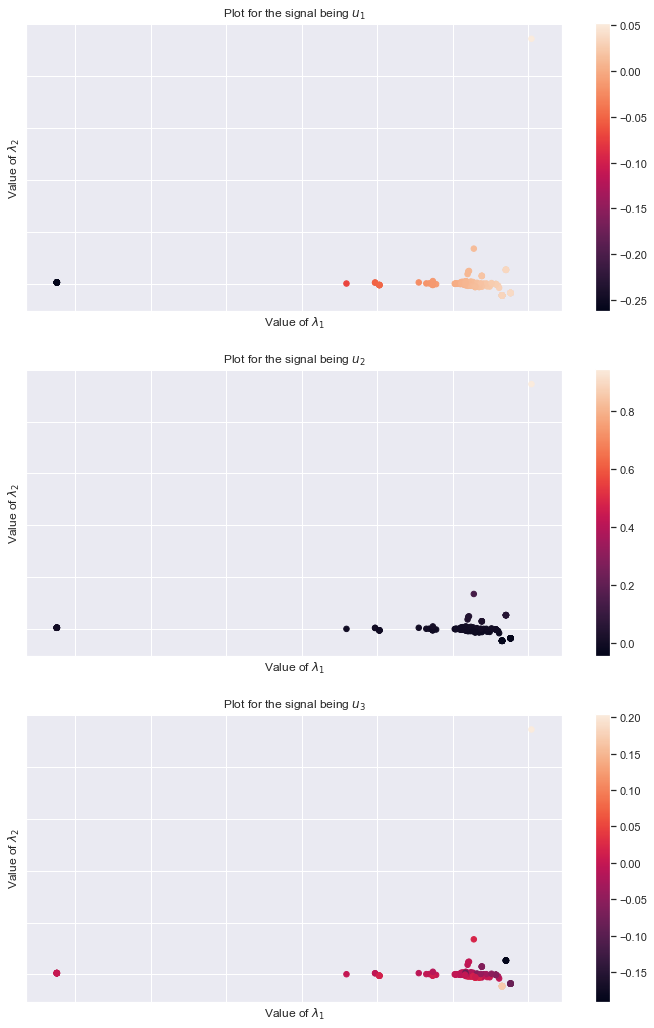

In [48]:
plt.figure(figsize=(12, 18))

# Plot the first 3 Fourier basis vectors
for i in range(3):
    plt.subplot(311 + i)
    plot_signal(embedding[:, i])
    plt.title('Plot for the signal being $u_{'+ str(1 + i)+'}$')

plt.show()



From there, we see that there are 3 blobs of points, which may suggest 3 communities. Moreover, the values of the signals change in a certain way that also suggest 2 or more clusters. 
So it seems that with this method, we won't be able to discover the continents just from the graph. 

Still in the next part, we compute a clustering with 3 clusters, as suggested before, in order to then visualize the cluster on the world map, to maybe see some of the continents as communities.

In order to really compute a clustering, we will use a Gaussian Mixture modelwith the EM algorithm.
Using the GMM model will allow us to have clusters that are non-spherical. We perform the clustering on the embedding of dimension 4.

In [49]:
predictions_gmm = GMM(n_components=3, covariance_type='full').fit_predict(embedding)

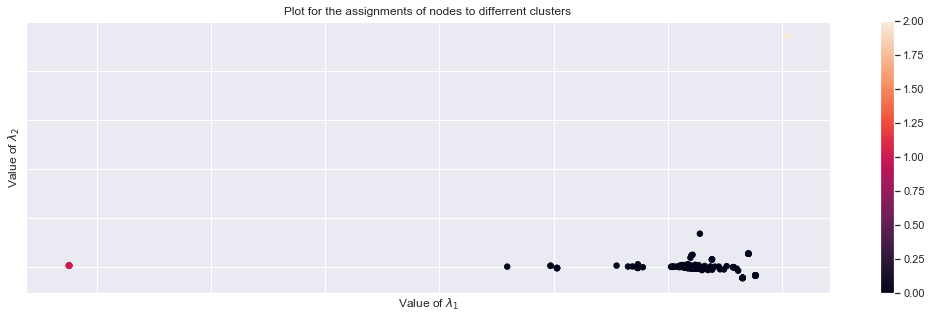

In [50]:
plt.figure(figsize=(18, 5))

plot_signal(predictions_gmm)
plt.title('Plot for the assignments of nodes to differrent clusters')

plt.show()

We now visualize thos 3 clusters directly on the world map:

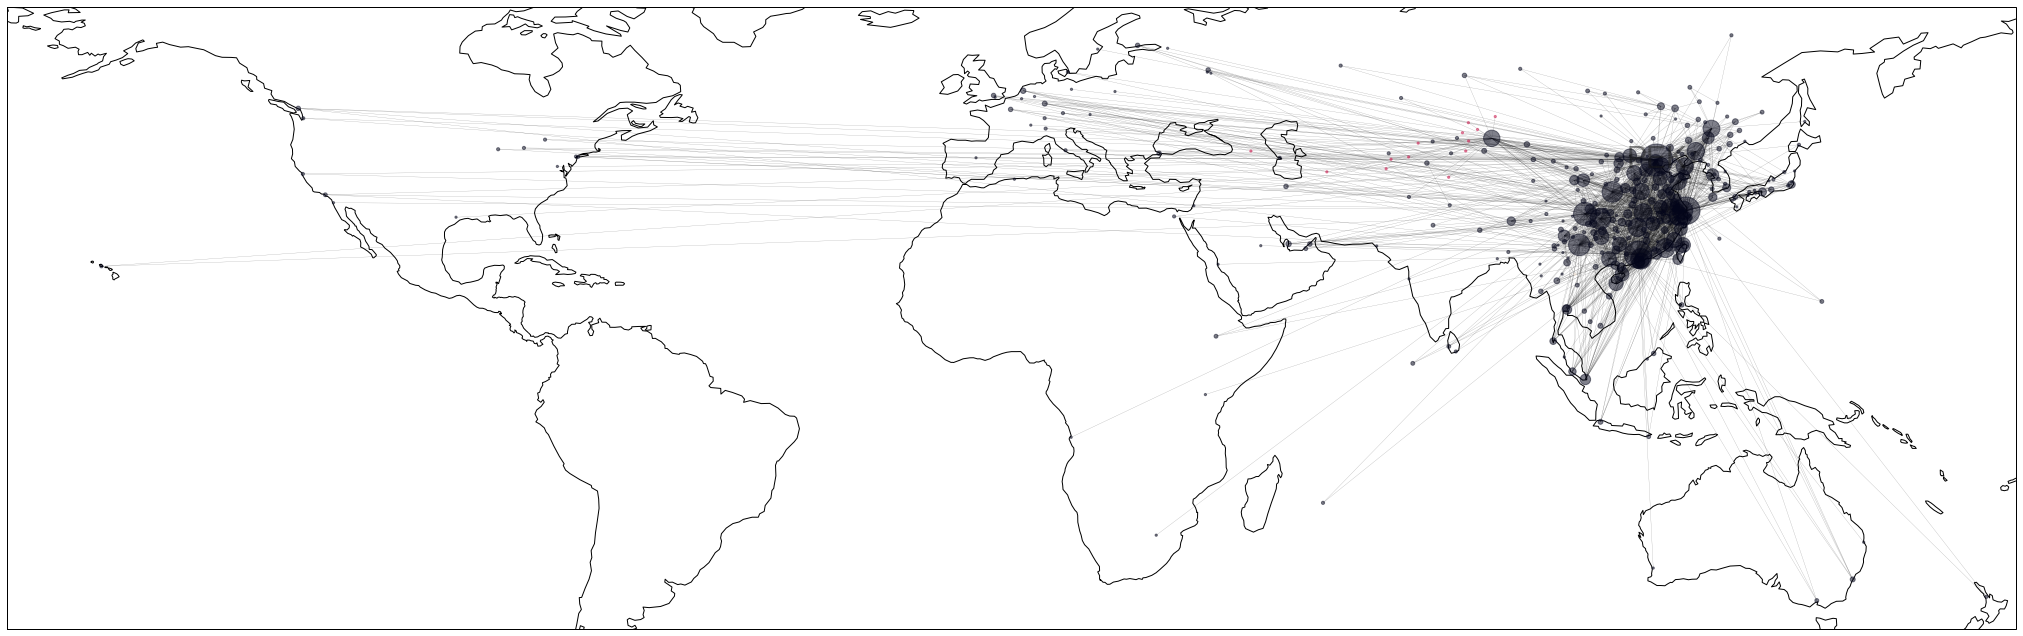

In [51]:
display_map(largest_cc, predictions_gmm)

So we see there that when using spectral clustering, it consider most of the graph as one community. 

Actually, by also computing the full eigendecomposition, and plotting the eigenvalues index against their actual value, we see the following:

(Note that we only plot the 20 first eigenvalues for a better visualization)

In [52]:
couple = list(zip(largest_cc.nodes, predictions_gmm))
_dict = {}
for key, value in couple:
    if value not in _dict:
        _dict[value] = []
    _dict[value].append(key)
partition = []
for index in _dict.keys():
    partition.append(_dict[index])

### Precision of clustering
To judge the precision of our clustering we use 2 notions : the coverage and the modularity. We will be able to judge the performance of our different clustering with a comparison of these values

In [53]:
nx.algorithms.community.coverage(largest_cc, partition)

0.9928571428571429

In [54]:
nx.algorithms.community.modularity(largest_cc, partition)

-2.3818200749920598e-05

In [55]:
e, U = scipy.linalg.eigh(laplacian.toarray())

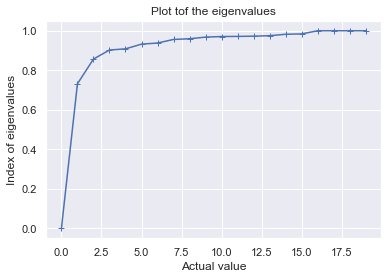

In [56]:
plt.plot(e[:20], '+-')
plt.xlabel('Actual value')
plt.ylabel('Index of eigenvalues')
plt.title('Plot tof the eigenvalues')

plt.show()

When using of spectral clustering as a mean to find communities, the plot above can help to find the number of communities. Indeed, what we call the "spectral gap" is supposed to indicate this number. It can be identified by a big gap in value between two successive eigenvalues.<br/>
Note that we can see such a gap only between the first two eigenvalues, suggesting that indeed there are only 2 communities. So it seems that via spectral clustering, it is not possible to recover the continents.

A reason why it is the case is that spectral clustering works well when there are **clear** clusters, which is not the case there. Even though there can be many connections within a continent, it can happen that there are also many edges between two continents.

## Finding communities by modularity maximization

Another popular way for detecting communities in a graph is by maximizing a quantity called ***modularity***. Modularity is a measure of the quality of a particular partition of a network into communities. The higher the modularity, the better the partition is. Indeed, networks with high modularity have many edges between nodes in the same community but very few edges between nodes in different communities.

So a natural way to find a good partition is simply to find one which has the maximum modularity, between all possible partitions. This is of course not possible, because of time complexity reasons, and so we present algorithms such as ***Greedy Modularity Maximization***, that aim to find the a partition of the graph into communities such that the modularity is particularly high.

We will also review the ***Louvain Method***, which also aim to maximize the modularity, and turns out to be a lot more efficient than the regular greedy approach.

### Greedy Modularity Maximization

We first use the Greedy Modularity Maximization, also called CNM algorithm:

In [57]:
 c2 = nx.algorithms.community.greedy_modularity_communities(largest_cc)

We then plot on the world map the first 5 communities found by the algorithm, hoping that they will represent the continents. The other nodes are just displayed in gray:

In [58]:
size = 4
cmap = plt.cm.get_cmap('gist_rainbow')
rgba = np.linspace(0.0, 1.0, num=size)
list_col=[]

for node in largest_cc.nodes:
    curr_len = len(list_col)
    for i in range(size):
        if node in c2[i]:
            list_col.append(cmap(rgba[i]))
            
    if len(list_col) == curr_len:
        list_col.append((0.5, 0.5, 0.5))

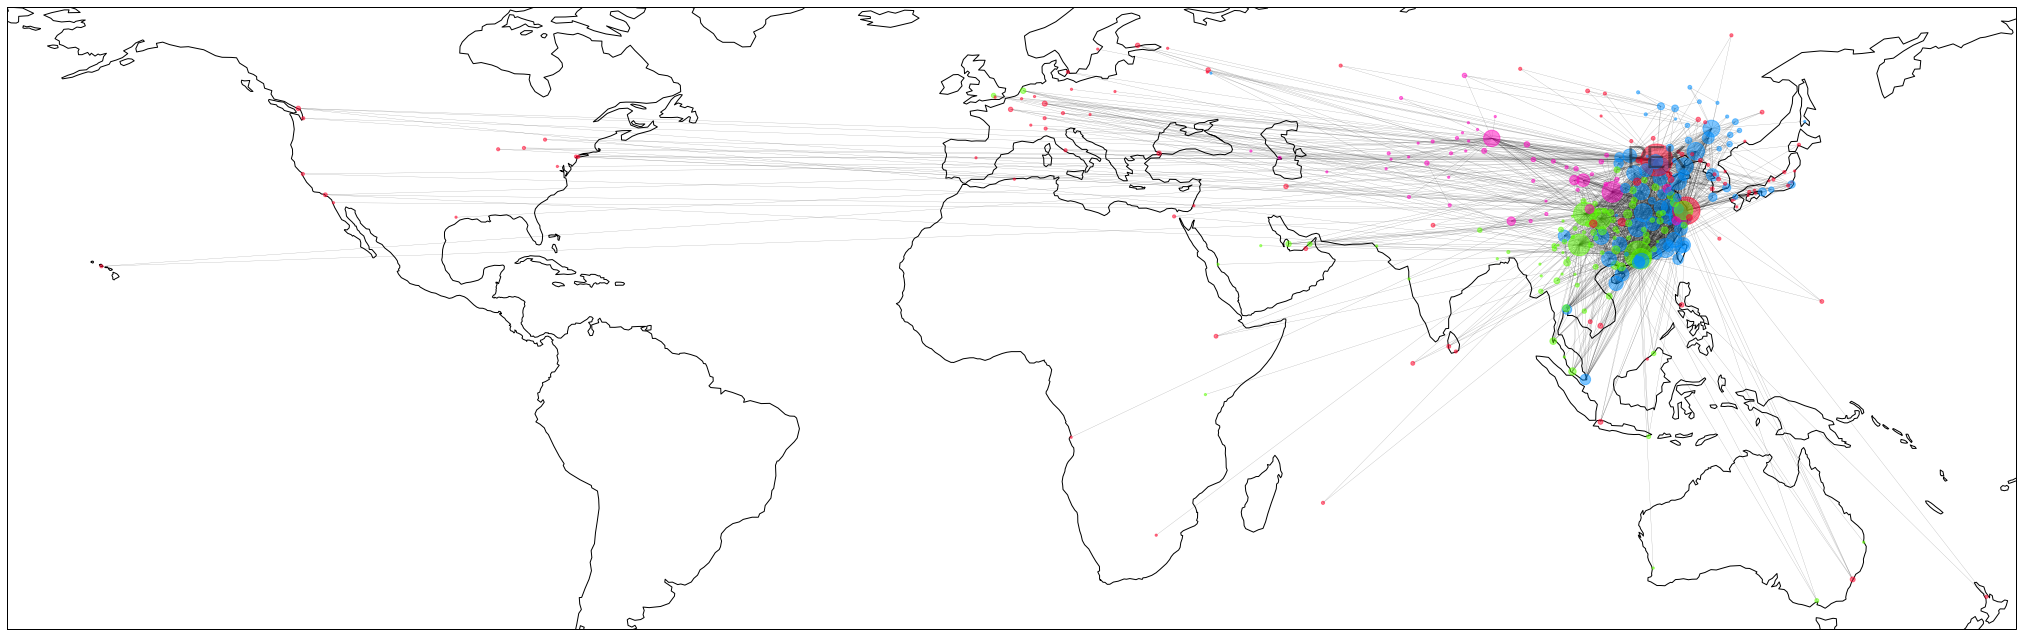

In [59]:
display_map(largest_cc, node_color=list_col)

Much better! It seems that by using the modularity, we can get better results. We see for example that Europe, America and Asia with Oceania are detected as communities. So this means that for each of these, there are way more connections inside them, compared to the number connections that leads outside of them.

In [60]:
nx.algorithms.community.quality.coverage(largest_cc,  c2)

0.5591836734693878

In [61]:
nx.algorithms.community.quality.modularity(largest_cc,  c2)

0.21133551124532343

## Louvain

In [62]:
from community import community_louvain 
#first compute the best partition
partition = community_louvain.best_partition(largest_cc)

#drawing
size = len(set(partition.values()))

cmap = plt.cm.get_cmap('gist_rainbow')
rgba = np.linspace(0.0, 1.0, num=size)
    
list_color = []
for n in largest_cc.nodes:
    list_color.append(cmap(rgba[partition[n]]))

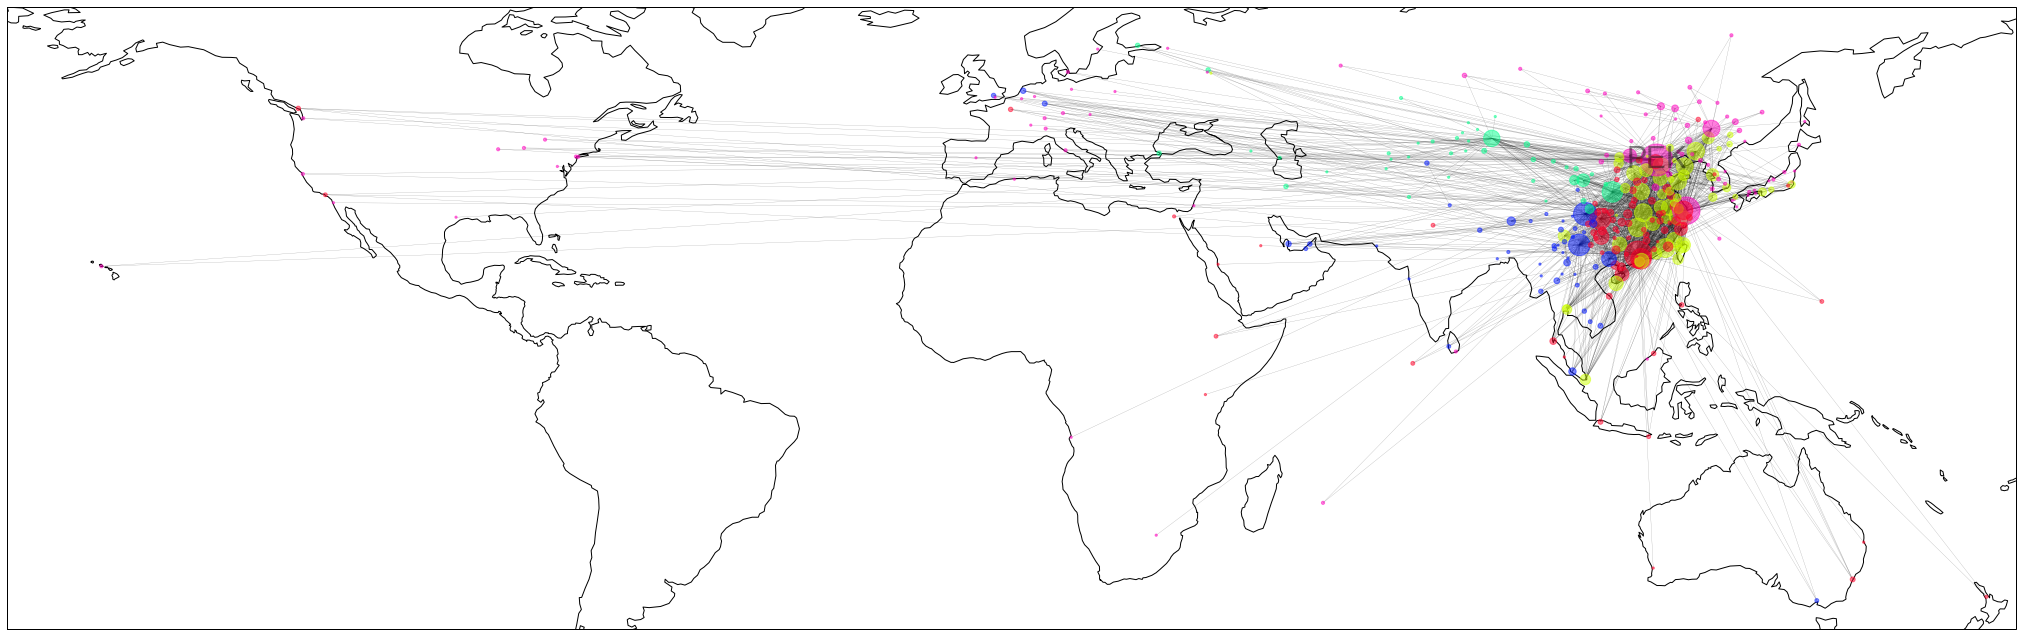

In [63]:
display_map(largest_cc, node_color=list_color)